# Rice Disease Classification Detection 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
data= pd.read_csv("./data/train.csv")
data.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [3]:
data.shape

(10407, 4)

In [4]:
data.label.unique().tolist()

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [5]:
data['variety'].unique().tolist()

['ADT45',
 'IR20',
 'KarnatakaPonni',
 'Onthanel',
 'Ponni',
 'Surya',
 'Zonal',
 'AndraPonni',
 'AtchayaPonni',
 'RR']

In [6]:
normal = data[data['label'] =='normal']
normal = normal[normal['variety'] =='ADT45']
five_normals = normal.image_id[:5].values
five_normals.tolist()

['100007.jpg', '100025.jpg', '100135.jpg', '100165.jpg', '100171.jpg']

In [7]:
dead = data[data['label'] =='dead_heart']
dead = dead[dead['variety'] =='ADT45']
five_deads= dead.image_id[:5].values
five_deads.tolist()

['101165.jpg', '102750.jpg', '108367.jpg', '109900.jpg', '100222.jpg']

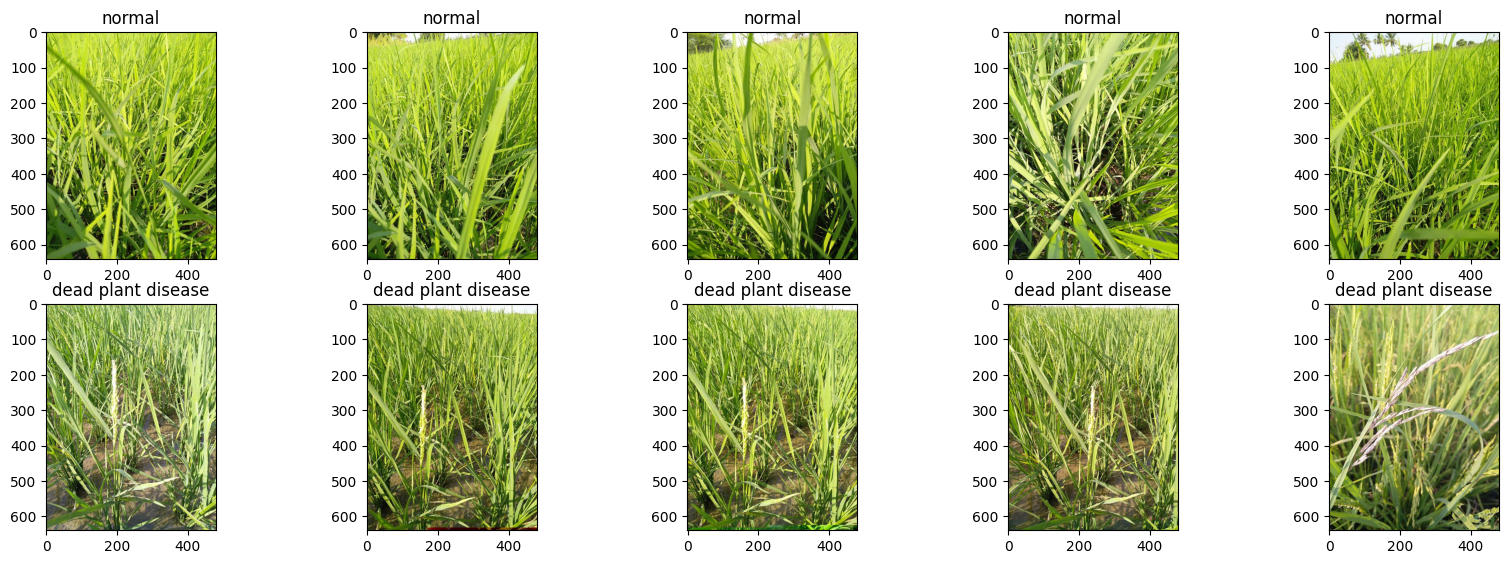

In [8]:
# make plot of images just to have an idea
plt.figure(figsize=(20,10))
columns = 5
path = './data/train_images/'
for i, image_loc in enumerate(np.concatenate((five_normals, five_deads))):
    plt.subplot(10//columns + 1, columns, i + 1)
    
    if i < 5:
        image=plt.imread(path +"normal/"+ image_loc)
        plt.title("normal")
    else:
        plt.title("dead plant disease")
        image=plt.imread(path +"dead_plant/"+ image_loc)
        
    plt.imshow(image)

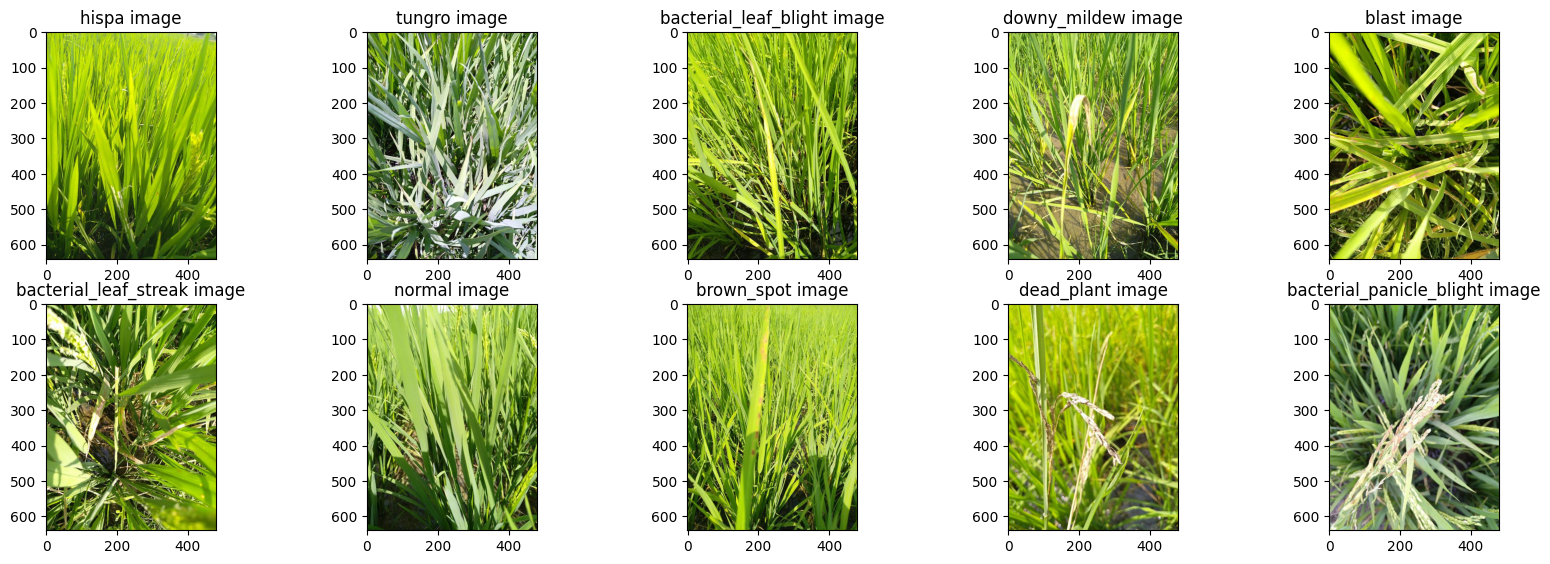

In [9]:
images = ['./data/train_images/hispa/106590.jpg',\
          './data/train_images/tungro/109629.jpg',\
          './data/train_images/bacterial_leaf_blight/109372.jpg',\
          './data/train_images/downy_mildew/102350.jpg',\
          './data/train_images/blast/110243.jpg',\
          './data/train_images/bacterial_leaf_streak/101104.jpg',\
          './data/train_images/normal/109760.jpg',\
          './data/train_images/brown_spot/104675.jpg',\
          './data/train_images/dead_plant/105159.jpg',\
          './data/train_images/bacterial_panicle_blight/101351.jpg',\
         ]
diseases = ['hispa','tungro','bacterial_leaf_blight','downy_mildew','blast','bacterial_leaf_streak',\
           'normal','brown_spot','dead_plant','bacterial_panicle_blight']
diseases = [disease + ' image' for disease in diseases]
plt.figure(figsize=(20,10))
columns = 5
for i, image_loc in enumerate(images):
    plt.subplot(len(images)//columns + 1, columns, i + 1)
    image=plt.imread(image_loc)
    plt.title(diseases[i])
    plt.imshow(image)

In [10]:
data.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [11]:
# encode both columns label and variety
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
data['variety'] = label_encoder.fit_transform(data['variety'])

data.head()

,image_id,label,variety,age
0,100330.jpg,0,0,45
1,100365.jpg,0,0,45
2,100382.jpg,0,0,45
3,100632.jpg,0,0,45
4,101918.jpg,0,0,45


In [12]:
# define parameter
batch_size = 32
img_height = 224
img_width = 224

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [14]:

val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_plant', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [17]:
normalization_layer=tf.keras.layers.Rescaling(1./255)

In [18]:
normal_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))
image_batch,labels_batch=next(iter(normal_ds))
first_image=image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


In [19]:
ATOTUNE=tf.data.AUTOTUNE

train_ds=train_ds.cache().prefetch(buffer_size=ATOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=ATOTUNE)

In [20]:
num_classes=len(class_names)
print(num_classes)

10


# Model 

In [21]:
model=tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [23]:
%%time
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.callbacks import EarlyStopping

early_stopping=EarlyStopping(patience=5)

history=model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=10,
                  callbacks=[early_stopping]
                  )
loss=model.evaluate(val_ds)
# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Epoch 1/10


261/261 ━━━━━━━━━━━━━━━━━━━━ 1449s 6s/step - accuracy: 0.1868 - loss: 2.1692 - val_accuracy: 0.3542 - val_loss: 1.8063
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 2238s 9s/step - accuracy: 0.4094 - loss: 1.6970 - val_accuracy: 0.5550 - val_loss: 1.3531
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 11709s 45s/step - accuracy: 0.5918 - loss: 1.1953 - val_accuracy: 0.6420 - val_loss: 1.1540
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 2538s 10s/step - accuracy: 0.7273 - loss: 0.8270 - val_accuracy: 0.7078 - val_loss: 1.0215
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 1891s 7s/step - accuracy: 0.7932 - loss: 0.6312 - val_accuracy: 0.7453 - val_loss: 0.8961
Epoch 6/10
155/261 ━━━━━━━━━━━━━━━━━━━━ 11:02 6s/step - accuracy: 0.8173 - loss: 0.5590

# Observation 
1. The shape of data is (10407, 4).
2. Total Unique number of disease.
3. Total variety of Rice is 10.
